Hello All ! This is pretty basic tutorial to start off with **Convolutional networks**.

Let's start with a bit of introduction Convolutional neural networks are primarily used to classify images or identify pattern similarities between them. So a convolutional network receives a normal color image as a rectangular box whose width and height are measured by the number of pixels along those dimensions, and whose depth is three layers deep, one for each letter in RGB. Those depth layers are referred to as **channels**. For simplification needs we will only consider gray scale image here.

As images move through a convolutional network, different patterns are recognised just like a normal neural network. But here rather than focussing on one pixel at a time, a convolutional net takes in square patches of pixels and passes them through a **filter**. That filter is also a square matrix smaller than the image itself, and equal in size to the patch. It is also called a **kernel**.
![](https://ahmedbesbes.com/images/GIF.gif)


Well that's it with the theory let's get started with the practical.





**Import Libraries**

There are basically 4 type of libraries which you have to import

1. Pandas :- For reading / writing data
2. Matplotlib to display images
3. Tensorflow Keras models :- Need a model to predict right !! 
4. Tensorflow Keras layers :- Every NN needs layers and CNN needs well a couple of layers.

Layers needed by CNN
1. Conv2D :- Basic Convolutional layer . Here we will be using a 64 neuron layer
2. Dense :- Dense layer is needed by every neural network to finally output the result however every once in while using a Dense layer helps in making model learn.
3. MaxPooling :- CNN has a concept of max pooling. After every convoulution we get some values in a kernel. However in max pooling we select max kernel value.
4. Flatten:- Conv2D layer returns doesn't return a flatten data hence we need Flatten layer before feeding it into final Dense layer


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import zipfile

with zipfile.ZipFile("../input/train.zip","r") as z:
    z.extractall(".")
    
with zipfile.ZipFile("../input/test1.zip","r") as z:
    z.extractall(".")

# Any results you write to the current directory are saved as output.

#print(os.listdir("/kaggle/working/train"))

['test1.zip', 'train.zip', 'sampleSubmission.csv']


We need to train a model first so we will check training data In the below code we are iterating through all images in train folder and then we will split image name with deliminiter "." We have names like dog.0, dog.1, cat.2 etc.. Hence after splitting we are gonna get results like "dog', "cat" as category value of the image. To make this example more easy we will consider dog as "1" and cat as "0"

Now every image is actually a set of pixels so how to get our computer know that. Its simple convert all those pixels into an array. So we are going to use here a **cv2** library to read our image into an array and also it will read as a gray scale image.

>cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)

Now we have got here images of all sizes . We have landscape, portrait etc etc.. We need to make them all of a single size so it can be analysed pretty easily. How to do that very very simple again. Use cv2

>cv2.resize(img_array, dsize=(80, 80))

Ok so we have got image array and its resized but do you believe whatever I just did was correct. Was the resizing of 80 X 80 good or is it bad. Should check it. How can we do that. There is one answer matplotlib. Using the below code we can display the image.

>plt.imshow(new_img_array,cmap="gray")

Please run the below the code to get better understanding. I have applied break here to just display 1 image. You can try out with 50 X 50 or 100 X100 to see the difference.




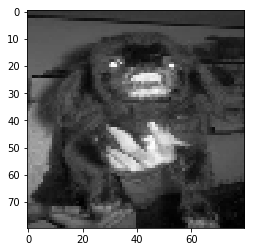

In [2]:
main_dir = "/kaggle/working/"
train_dir = "train"
path = os.path.join(main_dir,train_dir)

for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break


Okay so the above code was more for understanding purpose. Nowe we will get to the real part of coding here.

Declare your training array X and your target array y. Here X will be the array of pixels and y will be value 0 or 1 indicating its a dog or cat
Write convert function to map category "dog" or "cat" into 1 and 0

Create a function create_test_data which takes all training images into a loop. Converts into image array.Resize image into 80 X80. Append image into X array. Append category value into y array.

In [3]:
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X.append(new_img_array)
        y.append(category)
    

Now what..

Call the function

But also later convert X and y into numpy array We also have to reshape X with the below code

np.array(X).reshape(-1, 80,80,1)

I really don't know why we are using reshaping here. If anyone knows please do write in comments


In [4]:
create_test_data(path)
X = np.array(X).reshape(-1, 80,80,1)
y = np.array(y)

If you want to save your processed training (X) and target (y) you can use **pickle**. Please refer the below code for this. I wrote this to experiment but its not really needed. But anyways I still think its better to learn. :)

In [5]:
#import pickle

#pickle.dump( X, open( "train_x", "wb" ) )
#pickle.dump( y, open( "train_y", "wb" ) )


If you see the values of X you can see a variety of values between 0- 255 . Its because every pixel has different density of black and white. But with the wide range of values it becomes difficult for a training model to learn ( sometimes memorize ). 

How to resolve this And you guessed it right . You can **normalize** the data. We can use Keras normalize here also . But well we already know all values are having range between 0-255 so we can just divide it by 255 and get all values scaled between 0 -1

That's what we have done below. You can skip this step to see the difference between accuracy. Don't believe everything I say. Experiment and see for yourself


In [6]:
#Normalize data
X = X/255.0

Enough of data processing I wanna train :)
Here are the steps to do define our CNN model

1. Define a Sequential model
2. Start adding layers to it.
3. First we will add a Conv2D layer with 64 nodes and kernel size of (3,3). You can also experiment with different values here like 32, 128 etc. Also we have to specify input shape which is your X shape. Activation we will take 'relu' for now however there are many others to experiment with.
4. Now after every Conv layer we always do max pooling so we will add max pooling layer with a size of (2,2) 
5. We will repeat this combination again because come on 2 is better than one. Haha. We you can also add 3 or more convolution layers but keep in mind the more layers you add more time it will take to train.
6. But we don't have much time so we will add a flatten layer now. As we have to feed our data to Dense layer later.
7. We will now add a Dense layer of 64 nodes. Note for all these layers we are using activation as 'relu' because I found results better with this. You can skip specifying activation but this might make a model a conveniently linear which might not work for us.
8. In the end for getting our result we will add final Dense layer . Activation can be sigmoid or softmax (if you need probability use sigmoid else use softmax). Here I have used sigmoid.
9. Finally we will compile the model . There are 3 things to mention here . Loss, Optimizer, Metrics

**Loss** :- To make our model better we either minimize loss or maximize accuracy. NN always minimize loss. To measure it we can use different formulas like 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used binary_crossentropy

**Optimizer** :- If you know a lil bit about mathematics of machine learning you might be familier with local minima or global minima or cost function. To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is **adam**

**Metrics** :- This is to denote the measure of your model. Can be accuracy or some other metric.
        

In [7]:
model = Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(Conv2D(64,(3,3), activation = 'relu', input_shape = X.shape[1:]))
model.add(MaxPooling2D(pool_size = (2,2)))
# Add another:
model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
# Add a softmax layer with 10 output units:
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

Now we will fit our model with training data.

Epochs :- How many times our model will go through data

Batch size :- How much amount of data at once you wanna pass through the model

validation_split :- How much amount of data (in this case its 20 %) you will need to check cross validation error

In [8]:
model.fit(X, y, epochs=1, batch_size=32, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/1
20000/20000 [==============================] - 9s 443us/step - loss: 0.6024 - acc: 0.6667 - val_loss: 0.5212 - val_acc: 0.7424


Now we have to preporcess our test data also same as that our training data.

In [9]:
train_dir = "test1"
path = os.path.join(main_dir,train_dir)
#os.listdir(path)

X_test = []
id_line = []
def create_test1_data(path):
    for p in os.listdir(path):
        id_line.append(p.split(".")[0])
        img_array = cv2.imread(os.path.join(path,p),cv2.IMREAD_GRAYSCALE)
        new_img_array = cv2.resize(img_array, dsize=(80, 80))
        X_test.append(new_img_array)
create_test1_data(path)
X_test = np.array(X_test).reshape(-1,80,80,1)
X_test = X_test/255

Ok. Now the time has come to finally
**PREDICT**

so feed your model with test data to predict

In [10]:
predictions = model.predict(X_test)

We are rounding the result here as we used sigmoid function and we got the probablity values in our predicted dataset

In [11]:
predicted_val = [int(round(p[0])) for p in predictions]

Now you have to make submission data frame to submit your resultset

In [12]:
submission_df = pd.DataFrame({'id':id_line, 'label':predicted_val})

Write your data frame to a csv file

In [13]:
submission_df.to_csv("submission.csv", index=False)

And Voila we are done !!

Please do read this kernel and leave your comments for feedback and questions.

Thanks all :)